# Industrial Applications of Artificial Intelligence - Wind Speed Forecasting

### This notebook is part of the first hand-in regarding the primary sector in the lecture Industrial Applications of AI by Niklas Sabel (Matr. no. 1599748)

Due to excessive use of resources and climate change, the biggest challenge in human history will be the transformation of our way of living in a more considerate and mindful future. Renewable energies play a vital part in this transformation. Sources like wind, sun and water need to replace fossil materials. Energy production can be improved if plant operators are able to predict the predict natural forces and use them as efficient as possible. For this reason we will investigate different models for time series analysis of windspeed data. Since the dataset also contains a variety of different features. So, we want to explore if we can also predict the windspeed with classical algorithms.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import datetime
import ipyparallel as ipp
import os
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from scipy.stats import boxcox
import warnings
from arch import arch_model

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from platform import python_version
if python_version() < '3.8':
    import pickle5 as pickle
else:
    import pickle

In [2]:
def drop_correlated_features(df, thr=0.8):
    """
    Function to detect all correlated features
    :param df: general dataframe and threshold for the correlation param
    :return: dataframe without correlated features
    """
    correlated_features = set()
    correlation_matrix = df.corr()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > thr:
                print(
                    f"The following features are correlated: {correlation_matrix.columns[i]} and {correlation_matrix.columns[j]}. Correlation = {round(abs(correlation_matrix.iloc[i, j]), 2)}")
                colname = correlation_matrix.columns[j]
                correlated_features.add(colname)
    print(f"Drop the following features: {correlated_features}")
    # drop correlated features
    df = df.drop(columns=correlated_features)

    return df

## I. Import data time series cleaning

The dataset can be found on kaggle unter the following [url](https://www.kaggle.com/datasets/theforcecoder/wind-power-forecasting). In consists of 118.224 timestamps in the intervall between Jan 2018 to Mar 2020 of a wind turbine at a 10 minute frequency. We will try to give a short explanation of the features that have been collected by sensors in the following.
* Timestamp: Timestamp of the dataset in 10 minute steps
* Active Power: Power that was produced by the turbine
* AmbientTemperature: Surrounding temperature of the system
* BearingShaftTemperature: Temperature of the shaft of the turbine
* Blade1PitchAngle: The angle between the propeller blade chord line and the plane of rotation of propeller 1
* Blade2PitchAngle: The angle between the propeller blade chord line and the plane of rotation of propeller 2
* Blade3PitchAngle: The angle between the propeller blade chord line and the plane of rotation of propeller 3
* ControlBoxTemperature: Temperature of the control box
* GearboxBearingTemperature: Temperature of the gearbox bearing		
* GearboxOilTemperature: Temperature of the gearbox oil		
* GeneratorRPM: Generator rotation speed
* GeneratorWinding1Temperature:	Temperature of generator winding 1
* GeneratorWinding2Temperature: Temperature of generator winding 1
* HubTemperature: Temperature of the hub		
* MainBoxTemperature: Temperature of the main box	
* NacellePosition: A nacelle is a cover housing that houses all of the generating components
* ReactivePower: idle power of the generator	
* RotorRPM:	Rotor rotation speed
* TurbineStatus: Status of the Turbine
* WTG: no further information, always the same value
* WindDirection: Cardinal direction the wind is coming from	
* WindSpeed: Wind speed, target variable

In [3]:
path = '../../src/data/Abgabe_1'

In [4]:
#import data and drop WTG as it is always the same value
df_turbine = pd.read_csv(os.path.join(path, 'Turbine_Data.csv')).rename(columns={'Unnamed: 0':'timestamp'}).drop(columns=['WTG'])
df_turbine.head(5)

,timestamp,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,...,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
0,2017-12-31 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-12-31 00:10:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-12-31 00:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-12-31 00:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-12-31 00:40:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
type(df_turbine.timestamp[0])

str

In a first step we will transform the timestamp string into a datetime type to be able to better work with it.


In [6]:
df_turbine['timestamp'] = pd.to_datetime(df_turbine['timestamp'], format='%Y-%m-%d %H:%M:%S')

We will now reduce the dataset to hourly measures by only keeping every sixth entry and reduce our set to around 20.000 entries.

In [7]:
df_turbine_filtered = df_turbine.iloc[::6, :].reset_index(drop=True)

In [8]:
df_turbine_filtered

,timestamp,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,...,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
0,2017-12-31 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-12-31 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-12-31 02:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-12-31 03:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-12-31 04:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19699,2020-03-30 19:00:00+00:00,719.050113,28.451522,50.551569,-1.000329,-0.566086,-0.566086,0.0,65.632074,55.696751,...,81.755016,81.026067,42.007101,40.651004,182.00,144.977105,11.853638,2.0,182.00,6.912979
19700,2020-03-30 20:00:00+00:00,577.479083,28.114306,49.231853,-1.000329,-0.566086,-0.566086,0.0,67.418710,57.837785,...,75.813478,75.033262,40.996185,39.835167,188.00,117.667818,11.206096,2.0,188.00,6.203331
19701,2020-03-30 21:00:00+00:00,301.834096,28.280692,47.901967,-0.697151,-0.359015,-0.359015,0.0,65.944538,59.086684,...,70.770656,69.828203,40.003815,39.319438,199.40,62.384907,9.339114,2.0,199.40,5.152047
19702,2020-03-30 22:00:00+00:00,186.146124,27.832195,46.656487,0.201022,0.635737,0.635737,0.0,62.980141,57.115489,...,63.407208,62.452566,39.992892,37.735635,187.25,38.207072,9.234119,2.0,187.25,4.518272


We see that we have values at the beginning without windspeed data. We will discard the values in the beginning of the time series until we have a first measured windspeed. That leaves us with around 8.000 entries.

In [9]:
# identify the rows with some NaN
s = df_turbine_filtered.notnull().all(1)

# remove those with NaN at beginning and at the end:
df_turbine_clean = df_turbine_filtered.loc[s.idxmax():s[::-1].idxmax()].reset_index(drop=True)

In [10]:
df_turbine_clean

,timestamp,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,...,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
0,2019-05-06 15:00:00+00:00,-5.768376,38.992667,46.419196,47.399521,48.299502,48.299502,0.0,56.761226,55.807661,...,60.277575,59.855694,46.004238,51.900000,93.250000,-12.594477,0.550434,129.0,93.250000,2.161460
1,2019-05-06 16:00:00+00:00,-4.521693,38.993935,46.054246,NaN,NaN,NaN,0.0,56.167488,55.129876,...,58.225242,57.722183,46.003815,52.569364,NaN,-9.770303,NaN,1.0,NaN,1.740130
2,2019-05-06 17:00:00+00:00,-5.646388,38.829261,45.670467,85.000380,84.999664,84.999664,0.0,55.676785,54.401083,...,57.119178,56.448779,45.542915,52.425000,198.714286,-13.168056,0.000000,512.0,198.714286,1.286815
3,2019-05-06 18:00:00+00:00,589.893812,36.170749,46.489420,-1.008620,-0.493883,-0.493883,0.0,66.251776,58.078406,...,62.280167,61.578706,45.996185,47.787500,246.000000,119.285757,11.125503,2.0,246.000000,5.952220
4,2019-05-06 19:00:00+00:00,492.365107,35.533626,42.427520,NaN,NaN,NaN,0.0,60.910858,59.494276,...,69.118831,68.324718,41.396566,40.693750,NaN,99.508529,10.530480,2.0,NaN,6.077289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7900,2020-03-30 19:00:00+00:00,719.050113,28.451522,50.551569,-1.000329,-0.566086,-0.566086,0.0,65.632074,55.696751,...,81.755016,81.026067,42.007101,40.651004,182.000000,144.977105,11.853638,2.0,182.000000,6.912979
7901,2020-03-30 20:00:00+00:00,577.479083,28.114306,49.231853,-1.000329,-0.566086,-0.566086,0.0,67.418710,57.837785,...,75.813478,75.033262,40.996185,39.835167,188.000000,117.667818,11.206096,2.0,188.000000,6.203331
7902,2020-03-30 21:00:00+00:00,301.834096,28.280692,47.901967,-0.697151,-0.359015,-0.359015,0.0,65.944538,59.086684,...,70.770656,69.828203,40.003815,39.319438,199.400000,62.384907,9.339114,2.0,199.400000,5.152047
7903,2020-03-30 22:00:00+00:00,186.146124,27.832195,46.656487,0.201022,0.635737,0.635737,0.0,62.980141,57.115489,...,63.407208,62.452566,39.992892,37.735635,187.250000,38.207072,9.234119,2.0,187.250000,4.518272


In [11]:
y = df_turbine_clean['WindSpeed'].values
x = df_turbine_clean['timestamp'].values

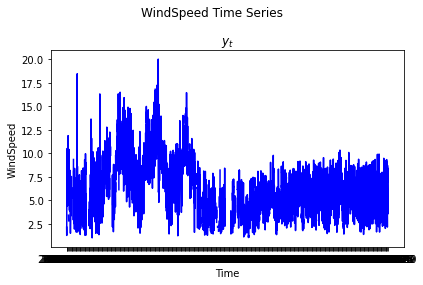

In [12]:
fig, axes = plt.subplots()
title = '$y_t$'

axes.plot(x, y, color='b')
axes.set_xticks(x[::20])
axes.set_title(title)
axes.set_xlabel('Time')
axes.set_ylabel('WindSpeed')
fig.suptitle('WindSpeed Time Series')
fig.tight_layout()

We can clearly see that there are missing values inside the time series, so we try to cope with them. Lets have a look on how many data points are missing. Unfortunately we cannot make use of the activePower variable, as we in most of the cases both of them are missing. 

In [13]:
df_turbine_clean[(df_turbine_clean.WindSpeed.isnull()==True)]

,timestamp,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,...,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
44,2019-05-08 11:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,2019-05-08 12:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,2019-05-08 13:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,2019-05-08 18:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110,2019-05-11 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6996,2020-02-22 03:00:00+00:00,NaN,22.845699,40.506067,NaN,NaN,NaN,0.0,61.944446,54.954932,...,56.753577,56.056116,31.001907,33.708333,NaN,NaN,9.307053,NaN,NaN,NaN
6997,2020-02-22 04:00:00+00:00,NaN,24.400282,40.079871,NaN,NaN,NaN,0.0,61.744262,54.626072,...,55.483554,54.735377,31.001907,35.187500,NaN,NaN,9.461089,NaN,NaN,NaN
6998,2020-02-22 05:00:00+00:00,NaN,26.200871,40.056477,NaN,NaN,NaN,0.0,62.834811,55.289297,...,57.113493,56.382524,31.013073,37.039333,NaN,NaN,9.940807,NaN,NaN,NaN
7571,2020-03-17 02:00:00+00:00,NaN,24.735575,42.434153,NaN,NaN,NaN,0.0,60.218610,54.796382,...,58.297406,57.426419,35.003815,35.437500,NaN,NaN,9.240434,NaN,NaN,NaN


In [14]:
df_turbine_clean[(df_turbine_clean.WindSpeed.isnull()==True) & (df_turbine_clean.ActivePower.isnull()==True)]

,timestamp,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,...,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
44,2019-05-08 11:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,2019-05-08 12:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,2019-05-08 13:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,2019-05-08 18:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110,2019-05-11 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6996,2020-02-22 03:00:00+00:00,NaN,22.845699,40.506067,NaN,NaN,NaN,0.0,61.944446,54.954932,...,56.753577,56.056116,31.001907,33.708333,NaN,NaN,9.307053,NaN,NaN,NaN
6997,2020-02-22 04:00:00+00:00,NaN,24.400282,40.079871,NaN,NaN,NaN,0.0,61.744262,54.626072,...,55.483554,54.735377,31.001907,35.187500,NaN,NaN,9.461089,NaN,NaN,NaN
6998,2020-02-22 05:00:00+00:00,NaN,26.200871,40.056477,NaN,NaN,NaN,0.0,62.834811,55.289297,...,57.113493,56.382524,31.013073,37.039333,NaN,NaN,9.940807,NaN,NaN,NaN
7571,2020-03-17 02:00:00+00:00,NaN,24.735575,42.434153,NaN,NaN,NaN,0.0,60.218610,54.796382,...,58.297406,57.426419,35.003815,35.437500,NaN,NaN,9.240434,NaN,NaN,NaN


Lets see if we can make use of the rotor rotation speed to fill in missing values for WindSpeed. The assumption would be that the higher the rotation speed, the higher the WindSpeed. So, we will make use of the ratio of WindSpeed to rotation speed by creating a new variable and fill missing values with the median as a robust measure.

In [15]:
df_turbine_clean[(df_turbine_clean.WindSpeed.isnull()==True) & (df_turbine_clean.RotorRPM.isnull()==True)]

,timestamp,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,...,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
44,2019-05-08 11:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,2019-05-08 12:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,2019-05-08 13:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,2019-05-08 18:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110,2019-05-11 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6537,2020-02-03 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6538,2020-02-03 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6539,2020-02-03 02:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6540,2020-02-03 03:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df_turbine_clean['ratio_rotation_speed'] = df_turbine_clean.WindSpeed/df_turbine_clean.RotorRPM

In [17]:
#save the median rotation and fill up the columns, where a rotation speed is given by rotation speed*median
median_rotation = df_turbine_clean.ratio_rotation_speed.median()
median_rotation

0.5666605456179388

In [18]:
#get indices where rotation speed is given
index_rot = df_turbine_clean[(df_turbine_clean.WindSpeed.isnull()==True) & (df_turbine_clean.RotorRPM.isnull()==False)].index.to_list()
#set the values 
for i in index_rot:
    df_turbine_clean.at[i,'WindSpeed'] = df_turbine_clean.at[i,'RotorRPM']*median_rotation

In [19]:
y = df_turbine_clean['WindSpeed'].values
x = df_turbine_clean['timestamp'].values

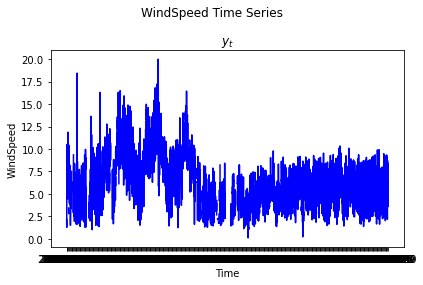

In [20]:
fig, axes = plt.subplots()
title = '$y_t$'

axes.plot(x, y, color='b')
axes.set_xticks(x[::20])
axes.set_title(title)
axes.set_xlabel('Time')
axes.set_ylabel('WindSpeed')
fig.suptitle('WindSpeed Time Series')
fig.tight_layout()

We can see that we could fill some gaps and the data is still reasonable. We could try to do the same with Generator Rotation Speed, as we assume the same behaviour there. But unfortunately in the remaining cases there is aslo never a Generator Rotation Speed given. Especially the part in the middle of the time series will be problematic for linear interpolation. However we can clearly see that is seems that the distribution in the middle seems to have the similar behaviour afterwards. So, we assume that we can use the behaviour from the following months to fill up the gap.

In [21]:
#pd.set_option('display.max_rows', None)

In [22]:
df_turbine_clean[(df_turbine_clean.WindSpeed.isnull()==True)]

,timestamp,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,...,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed,ratio_rotation_speed
44,2019-05-08 11:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,2019-05-08 12:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,2019-05-08 13:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,2019-05-08 18:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110,2019-05-11 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6537,2020-02-03 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6538,2020-02-03 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6539,2020-02-03 02:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6540,2020-02-03 03:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It seems that there are values missing the are between September 2019 and October 2019. Due to the plot, it is reasonable that we have the same distribution as in November 2019. So we insert the same values for September and October if those are missing.

In [23]:
df_turbine_clean[(df_turbine_clean.timestamp > '2019-09-01')& (df_turbine_clean.timestamp < '2019-11-01') & (df_turbine_clean.WindSpeed.isnull()==True)]

,timestamp,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,...,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed,ratio_rotation_speed
2832,2019-09-01 15:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2837,2019-09-01 20:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2840,2019-09-01 23:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2841,2019-09-02 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2842,2019-09-02 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4193,2019-10-28 08:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4194,2019-10-28 09:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4195,2019-10-28 10:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4196,2019-10-28 11:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
list_sept_oct = df_turbine_clean[(df_turbine_clean.timestamp > '2019-09-01')& (df_turbine_clean.timestamp < '2019-11-01') & (df_turbine_clean.WindSpeed.isnull()==True)].index.to_list()
for i in list_sept_oct:
    # if month is september, we insert the value of august (2 months in future)
    if df_turbine_clean.timestamp[i].month == 9:
        df_turbine_clean.at[i,'WindSpeed'] = df_turbine_clean[df_turbine_clean.timestamp==(df_turbine_clean.timestamp[i] + pd.DateOffset(months=2))].WindSpeed
    # if month is october, we insert the value of august (1 months to future)
    if df_turbine_clean.timestamp[i].month == 10:
        df_turbine_clean.at[i,'WindSpeed'] = df_turbine_clean[df_turbine_clean.timestamp==(df_turbine_clean.timestamp[i] + pd.DateOffset(months=1))].WindSpeed

In [25]:
y = df_turbine_clean['WindSpeed'].values
x = df_turbine_clean['timestamp'].values

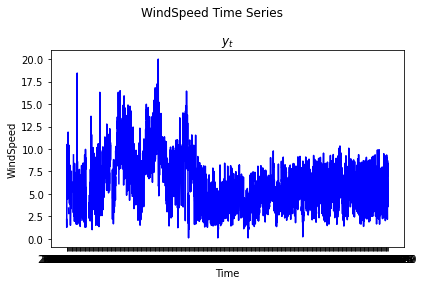

In [26]:
fig, axes = plt.subplots()
title = '$y_t$'

axes.plot(x, y, color='b')
axes.set_xticks(x[::20])
axes.set_title(title)
axes.set_xlabel('Time')
axes.set_ylabel('WindSpeed')
fig.suptitle('WindSpeed Time Series')
fig.tight_layout()

Now, as we do not have bigger gaps inside the time series. So, we are using linear polation to fill up the remaining NAs.

In [27]:
df_turbine_clean['WindSpeed'] = df_turbine_clean['WindSpeed'].interpolate(method="linear")

In [28]:
y = df_turbine_clean['WindSpeed'].values
x = df_turbine_clean['timestamp'].values

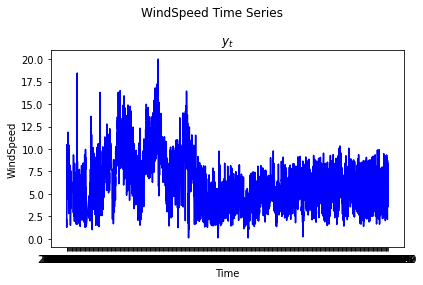

In [29]:
fig, axes = plt.subplots()
title = '$y_t$'

axes.plot(x, y, color='b')
axes.set_xticks(x[::20])
axes.set_title(title)
axes.set_xlabel('Time')
axes.set_ylabel('WindSpeed')
fig.suptitle('WindSpeed Time Series')
fig.tight_layout()

So, now we have filled all missing values. We may could do better with more sophisticated methods, especially in the small gap in the beginning. But the remaining time series seems good to go. We will therefore discard the auxiliary variable ratio and the variables ActivePower,GeneratorRPM and RotorRPM as this might be false predictors for the windspeed. We will also discard ControlBoxTemperature as it has only zero values.

In [30]:
# look at distribution
df_turbine_clean.describe().transpose().applymap("{:.2f}".format)

,count,mean,std,min,25%,50%,75%,max
ActivePower,7085.00,672.32,629.28,-38.52,104.06,457.28,1233.52,1768.14
AmbientTemperatue,6929.00,28.34,4.06,19.71,25.40,27.82,31.04,41.70
BearingShaftTemperature,6933.00,43.24,5.41,0.00,39.95,42.96,47.48,54.98
Blade1PitchAngle,6994.00,9.74,20.57,-1.47,-0.94,0.39,8.11,90.14
Blade2PitchAngle,6979.00,10.03,20.21,-2.41,-0.43,0.90,8.47,90.02
Blade3PitchAngle,6979.00,10.03,20.21,-2.41,-0.43,0.90,8.47,90.02
ControlBoxTemperature,6904.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
GearboxBearingTemperature,6938.00,64.78,10.65,0.00,58.57,65.32,71.76,82.14
GearboxOilTemperature,6928.00,57.77,7.01,26.82,53.88,57.32,62.37,70.65
GeneratorRPM,6917.00,1129.98,531.65,0.00,1029.90,1153.19,1571.98,1793.66


In [31]:
df_turbine_clean = df_turbine_clean.drop(columns=['ActivePower','GeneratorRPM','RotorRPM','ratio_rotation_speed','ControlBoxTemperature'])

## II. Feature cleaning and correlation

For a possible comparison to a feature based regression model, we will have a look at NaN values and correlated features. In the following, we will simply fill up the features with the median, as we do not want to extensively train a "normal" feature-based algorithm, but use it as a comparison. Otherwise we will focus on implementing time series models such as ARIMA and GARCH.

In [32]:
# we clearly see that we have a lot of NaN values inside our dataframe
df_turbine_clean.isna().sum()

timestamp                          0
AmbientTemperatue                976
BearingShaftTemperature          972
Blade1PitchAngle                 911
Blade2PitchAngle                 926
Blade3PitchAngle                 926
GearboxBearingTemperature        967
GearboxOilTemperature            977
GeneratorWinding1Temperature     979
GeneratorWinding2Temperature     974
HubTemperature                   974
MainBoxTemperature               969
NacellePosition                 2198
ReactivePower                    820
TurbineStatus                    907
WindDirection                   2198
WindSpeed                          0
dtype: int64

In [33]:
# Fill numeric rows with the median
for label, content in df_turbine_clean.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Fill missing numeric values with median since it's more robust than the mean
            df_turbine_clean[label] = content.fillna(content.median())

In [34]:
# look at distribution again
df_turbine_clean.describe().transpose().applymap("{:.2f}".format)

,count,mean,std,min,25%,50%,75%,max
AmbientTemperatue,7905.00,28.28,3.80,19.71,25.85,27.82,30.54,41.70
BearingShaftTemperature,7905.00,43.21,5.07,0.00,40.29,42.96,46.73,54.98
Blade1PitchAngle,7905.00,8.66,19.58,-1.47,-0.88,0.39,6.31,90.14
Blade2PitchAngle,7905.00,8.96,19.21,-2.41,-0.38,0.90,6.71,90.02
Blade3PitchAngle,7905.00,8.96,19.21,-2.41,-0.38,0.90,6.71,90.02
GearboxBearingTemperature,7905.00,64.84,9.98,0.00,59.64,65.32,70.27,82.14
GearboxOilTemperature,7905.00,57.72,6.57,26.82,54.54,57.32,60.98,70.65
GeneratorWinding1Temperature,7905.00,73.37,22.72,27.18,57.48,67.06,85.23,126.60
GeneratorWinding2Temperature,7905.00,72.72,22.76,26.94,56.69,66.26,84.81,125.89
HubTemperature,7905.00,36.87,4.38,0.00,34.01,37.00,39.99,48.00


We will now investigate possible correlations inside the feaatures and discard highly correlated featueres (correlation > 0.8) to not distort our algorithms.

C:\Users\Nikla\AppData\Local\Temp\ipykernel_5040\2824533823.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


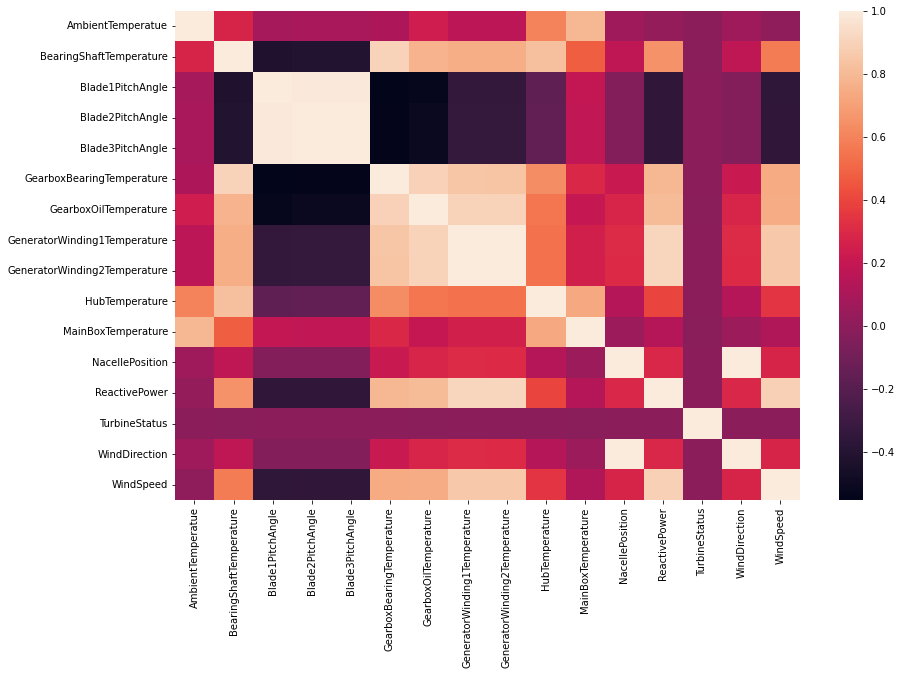

In [35]:
# investigate correlation heatmap
corrMatrix=df_turbine_clean.corr()
f=plt.figure(figsize=(14,9))
sns.heatmap(corrMatrix, annot=False)
f.show()

In [36]:
#drop Windspeed to not use it in the correlations of the explanatory variables
df_target = df_turbine_clean['WindSpeed']
df_turbine_cor = df_turbine_clean.drop(columns=['WindSpeed'])
# drop highly correlated features for a SVM baseline
df_turbine_cor = drop_correlated_features(df_turbine_cor)

The following features are correlated: Blade2PitchAngle and Blade1PitchAngle. Correlation = 0.99
The following features are correlated: Blade3PitchAngle and Blade1PitchAngle. Correlation = 0.99
The following features are correlated: Blade3PitchAngle and Blade2PitchAngle. Correlation = 1.0
The following features are correlated: GearboxBearingTemperature and BearingShaftTemperature. Correlation = 0.9
The following features are correlated: GearboxOilTemperature and GearboxBearingTemperature. Correlation = 0.9
The following features are correlated: GeneratorWinding1Temperature and GearboxBearingTemperature. Correlation = 0.84
The following features are correlated: GeneratorWinding1Temperature and GearboxOilTemperature. Correlation = 0.9
The following features are correlated: GeneratorWinding2Temperature and GearboxBearingTemperature. Correlation = 0.84
The following features are correlated: GeneratorWinding2Temperature and GearboxOilTemperature. Correlation = 0.9
The following features are

We discard the correlated features. There were some obvious examples like the position of each of the blades as they are fixed and always the same compared to the other blades. Also the temperatures seem to have a high correlation towards each other, what could be suspected if we do not take malfunctions and outliers into account.

In [37]:
#attach windspeed again for further processing
df_turbine_clean = pd.concat([df_turbine_cor, df_target], axis = 1)
df_turbine_clean.head(5)

,timestamp,AmbientTemperatue,Blade3PitchAngle,HubTemperature,MainBoxTemperature,ReactivePower,TurbineStatus,WindDirection,WindSpeed
0,2019-05-06 15:00:00+00:00,38.992667,48.299502,46.004238,51.900000,-12.594477,129.0,93.250000,2.161460
1,2019-05-06 16:00:00+00:00,38.993935,0.896114,46.003815,52.569364,-9.770303,1.0,182.000000,1.740130
2,2019-05-06 17:00:00+00:00,38.829261,84.999664,45.542915,52.425000,-13.168056,512.0,198.714286,1.286815
3,2019-05-06 18:00:00+00:00,36.170749,-0.493883,45.996185,47.787500,119.285757,2.0,246.000000,5.952220
4,2019-05-06 19:00:00+00:00,35.533626,0.896114,41.396566,40.693750,99.508529,2.0,182.000000,6.077289


As a last step, we will scale the features using the MinMaxScaler, since one can clearly see that the scales differ by a lot and would therefore distort our result.

In [38]:
#scale all features without WindSpeed
scale_features =['AmbientTemperatue','Blade3PitchAngle','HubTemperature','MainBoxTemperature','ReactivePower','TurbineStatus','WindDirection']
scaler = MinMaxScaler()
df_turbine_clean[scale_features] = scaler.fit_transform(df_turbine_clean[scale_features])

In [39]:
df_turbine_clean.head(5)

,timestamp,AmbientTemperatue,Blade3PitchAngle,HubTemperature,MainBoxTemperature,ReactivePower,TurbineStatus,WindDirection,WindSpeed
0,2019-05-06 15:00:00+00:00,0.876762,0.548620,0.958498,0.957017,0.187459,2.101774e-06,0.261204,2.161460
1,2019-05-06 16:00:00+00:00,0.876820,0.035730,0.958489,0.969360,0.193712,1.629282e-08,0.509804,1.740130
2,2019-05-06 17:00:00+00:00,0.869332,0.945705,0.948886,0.966698,0.186188,8.341923e-06,0.556623,1.286815
3,2019-05-06 18:00:00+00:00,0.748446,0.020691,0.958330,0.881184,0.479491,3.258564e-08,0.689076,5.952220
4,2019-05-06 19:00:00+00:00,0.719475,0.035730,0.862497,0.750378,0.435697,3.258564e-08,0.509804,6.077289


# III. Create train, validation and test set and compute feature based models.

In the next step, we will create a train, validation and test set with sizes 90%, 5% and 5% data and keep these sets for the remaining notebook to make the results comparable.

In [40]:
# set sizes and round them on full numbers
len_train = int(len(df_turbine_clean)*0.9+0.5)
len_val = int(len(df_turbine_clean)*0.05-0.25)
len_test = int(len(df_turbine_clean)*0.05-0.25)

In [41]:
# we create the datasets for our "normal" models SVM and RandomForest
X_train, y_train = df_turbine_clean[:len_train].drop(columns=['WindSpeed','timestamp']), df_turbine_clean[:len_train].WindSpeed
X_val, y_val = df_turbine_clean[len_train:len_train+len_val].drop(columns=['WindSpeed','timestamp']), df_turbine_clean[len_train:len_train+len_val].WindSpeed
X_test, y_test =  df_turbine_clean[len_train+len_val:].drop(columns=['WindSpeed','timestamp']), df_turbine_clean[len_train+len_val:].WindSpeed

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(7115, 7) (7115,)
(395, 7) (395,)
(395, 7) (395,)


In the following we define 4 measure functions that will help us evaluate our results. In particular mean error (me), mean absolute error (MAE), mean absolut percentage error (MAPE) and the root mean squared error (RMSE).

In [42]:
#me implementation
def me(predictions, targets):
    return np.mean(targets-predictions)

In [43]:
#mae implementation
def mae(predictions, targets):
    return np.mean(abs(targets- predictions))

In [44]:
#mape implementation
def mape(predictions, targets):
    return np.mean( abs( targets[targets>0]-predictions[targets>0] )/targets[targets>0] ) * 100

In [45]:
#rmse implementation
def rmse(predictions, targets):
    return np.sqrt( np.mean( (targets-predictions)**2 ))

We will compute a SVM, a random forest and a gradient boosting regression baseline for our data points to compare them to the values of the following models.

In [45]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
prediction = rf.predict(X_val)
me_score = me(prediction,y_val) 
mae_score = mae(prediction,y_val) 
mape_score = mape(prediction,y_val) 
rmse_score = rmse(prediction,y_val) 
print("The ME on test set: {:.4f}".format(me_score))
print("The MAE on test set: {:.4f}".format(mae_score))
print("The MAPE on test set: {:.4f}".format(mape_score))
print("The RMSE on test set: {:.4f}".format(rmse_score))

The ME on test set: 0.1306
The MAE on test set: 0.3378
The MAPE on test set: 7.1430
The RMSE on test set: 0.7230


In [46]:
from sklearn.svm import SVR

sv_regressor = SVR(kernel = 'rbf')
sv_regressor.fit(X_train, y_train)
prediction = sv_regressor.predict(X_val)
me_score = me(prediction,y_val) 
mae_score = mae(prediction,y_val) 
mape_score = mape(prediction,y_val) 
rmse_score = rmse(prediction,y_val) 
print("The ME on val set: {:.4f}".format(me_score))
print("The MAE on val set: {:.4f}".format(mae_score))
print("The MAPE on val set: {:.4f}".format(mape_score))
print("The RMSE on val set: {:.4f}".format(rmse_score))

The ME on val set: 0.1805
The MAE on val set: 0.3673
The MAPE on val set: 7.8450
The RMSE on val set: 0.7684


In [47]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)
prediction = gbr.predict(X_val)
me_score = me(prediction,y_val) 
mae_score = mae(prediction,y_val) 
mape_score = mape(prediction,y_val) 
rmse_score = rmse(prediction,y_val) 
print("The ME on val set: {:.4f}".format(me_score))
print("The MAE on val set: {:.4f}".format(mae_score))
print("The MAPE on val set: {:.4f}".format(mape_score))
print("The RMSE on val set: {:.4f}".format(rmse_score))

The ME on val set: 0.1336
The MAE on val set: 0.3451
The MAPE on val set: 7.4788
The RMSE on val set: 0.7309


In a following step, we try to improve the results by a voting ensemble consisting of the three models.

In [48]:
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
from sklearn.svm import SVR

rf = RandomForestRegressor()
sv_regressor = SVR(kernel = 'rbf')
gbr = GradientBoostingRegressor()

vo_reg = VotingRegressor([('rf', rf), ('svr', sv_regressor),('gbr',gbr)])
vo_reg.fit(X_train, y_train)
prediction = vo_reg.predict(X_val)
me_score = me(prediction,y_val) 
mae_score = mae(prediction,y_val) 
mape_score = mape(prediction,y_val) 
rmse_score = rmse(prediction,y_val) 
print("The ME on val set: {:.4f}".format(me_score))
print("The MAE on val set: {:.4f}".format(mae_score))
print("The MAPE on val set: {:.4f}".format(mape_score))
print("The RMSE on val set: {:.4f}".format(rmse_score))

The ME on val set: 0.1480
The MAE on val set: 0.3391
The MAPE on val set: 7.1820
The RMSE on val set: 0.7255


We see that the models are able to capture some patterns and that RF on its own performs best. It seems like the voting classifier gets confused by the other components. All in all the results for our feature based models are not that promising. Therefore, we will only use the RF-Regressor on the test data by training it with train and validation data first.

In [48]:
X_train_whol, y_train_whole = df_turbine_clean[:len_train+len_val].drop(columns=['WindSpeed','timestamp']), df_turbine_clean[:len_train+len_val].WindSpeed
print(X_train_whol.shape, y_train_whole.shape)

(7510, 7) (7510,)


In [49]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train_whol, y_train_whole)
prediction = rf.predict(X_test)
me_score = me(prediction,y_test) 
mae_score = mae(prediction,y_test) 
mape_score = mape(prediction,y_test) 
rmse_score = rmse(prediction,y_test) 
print("The ME on test set: {:.4f}".format(me_score))
print("The MAE on test set: {:.4f}".format(mae_score))
print("The MAPE on test set: {:.4f}".format(mape_score))
print("The RMSE on test set: {:.4f}".format(rmse_score))

The ME on test set: 0.2230
The MAE on test set: 0.4620
The MAPE on test set: 7.9563
The RMSE on test set: 0.9615


## IV. Time series: baseline and ARIMA

To begin with, we will compute a naive baseline for time series data. We use the persistence algorithm. Therefore, we use the value at the previous time step the predict the expected outcome at the next time step.

In [50]:
# set sizes and round them on full numbers
len_train = int(len(df_turbine_clean)*0.9+0.5)
len_val = int(len(df_turbine_clean)*0.05-0.25)
len_test = int(len(df_turbine_clean)*0.05-0.25)

### IV.I Baseline Persistence Algorithm

In [51]:
# create a lagged representation 
values = pd.DataFrame(df_turbine_clean['WindSpeed'].values)
df_turbine_lagged= pd.concat([values.shift(1), values], axis=1)
df_turbine_lagged.columns = ['t-1', 't+1']
#drop first row due to NaN
df_turbine_lagged = df_turbine_lagged.iloc[1:]
print(df_turbine_lagged.head(5))

        t-1       t+1
1  2.161460  1.740130
2  1.740130  1.286815
3  1.286815  5.952220
4  5.952220  6.077289
5  6.077289  5.533625


In [52]:
# we create the datasets for our persistence algorithm baseline, be careful that the first value in the train set is missing, as we do not have a previous value there 
X_train, y_train = df_turbine_lagged.values[:len_train-1,0], df_turbine_lagged.values[:len_train-1,1] 
X_val, y_val = df_turbine_lagged.values[len_train-1:len_train-1+len_val,0], df_turbine_lagged.values[len_train-1:len_train-1+len_val,1] 
X_test, y_test =  df_turbine_lagged.values[len_train-1+len_val:,0], df_turbine_lagged.values[len_train-1+len_val:,1] 

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(7114,) (7114,)
(395,) (395,)
(395,) (395,)


In [53]:
# persistence model to return actual input
def model_persistence(x):
    return x

In [54]:
# walk-forward validation,
predictions = list()
for x in X_val:
    yhat = model_persistence(x)
    predictions.append(yhat)
me_score = me(np.array(predictions),y_val) 
mae_score = mae(np.array(predictions),y_val) 
mape_score = mape(np.array(predictions),y_val) 
rmse_score = rmse(np.array(predictions),y_val) 
print("The ME on val set: {:.4f}".format(me_score))
print("The MAE on val set: {:.4f}".format(mae_score))
print("The MAPE on val set: {:.4f}".format(mape_score))
print("The RMSE on val set: {:.4f}".format(rmse_score))

The ME on val set: 0.0050
The MAE on val set: 0.8586
The MAPE on val set: 20.1519
The RMSE on val set: 1.1284


We see that our baseline does not perform pretty good as expected. It seems that wind is to stochastic and does change too often. Lets see how it behaves on the test set.

In [57]:
predictions = list()
for x in X_test:
    yhat = model_persistence(x)
    predictions.append(yhat)
me_score = me(np.array(predictions),y_test) 
mae_score = mae(np.array(predictions),y_test) 
mape_score = mape(np.array(predictions),y_test) 
rmse_score = rmse(np.array(predictions),y_test) 
print("The ME on val set: {:.4f}".format(me_score))
print("The MAE on val set: {:.4f}".format(mae_score))
print("The MAPE on val set: {:.4f}".format(mape_score))
print("The RMSE on val set: {:.4f}".format(rmse_score))

The ME on val set: -0.0068
The MAE on val set: 0.8628
The MAPE on val set: 17.8914
The RMSE on val set: 1.2244


We actually see that the behaviour improves on the test set with this simple baseline. That can be explained by the plot of the time series. As it seems that the behaviour becomes more similar the further we look at the end of our given dataset.

## IV.II Stationarity and ARIMA

Lets first try to model stationary. We will perform and ADF- and an KPSS-test. Although the tests indicate that the time series is already stationary, we can clearly see in the plot, that this is not the case yet, especially in the beginning of the series.

In [58]:
y = df_turbine_clean['WindSpeed'].values
x = df_turbine_clean['timestamp'].values

C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


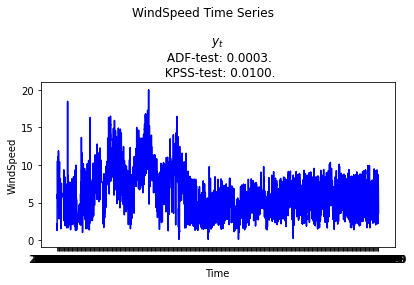

In [59]:
fig, axes = plt.subplots()
title = '$y_t$'

# plot data with different orders of differencing and tranformations
# make sure to choose appropriate settings for KPSS and ADF tests
axes.plot(x, y, color='b')
axes.set_xticks(x[::20])
title += '\n ADF-test: {:.4f}.'.format(adfuller(y, regression='ctt')[1])
title += '\n KPSS-test: {:.4f}.'.format(kpss(y, regression='ct', nlags='auto')[1])
axes.set_title(title)
axes.set_xlabel('Time')
axes.set_ylabel('WindSpeed')
fig.suptitle('WindSpeed Time Series')
fig.tight_layout()

Since we do not have a stationary series yet. We will use transformations and differencing to enforce stationarity. In the following, we use a boxcox transformation to adjust our data and 

In [60]:
# box cox transformation: returns transformed data, likelihood maximizing lambda and confidence intervals
_, lam, (min_ci, max_ci) = boxcox(y, lmbda=None, alpha=.9)
print(lam, (min_ci, max_ci))

0.369667861173309 (0.36719683818576543, 0.37214035089438846)


In [61]:
y_transf = boxcox(y, lmbda=0.369667861173309 )

C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


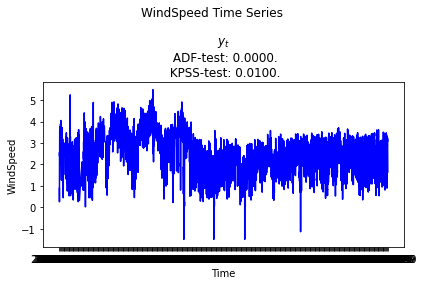

In [62]:
fig, axes = plt.subplots()
title = '$y_t$'

# plot data with different orders of differencing and tranformations
# make sure to choose appropriate settings for KPSS and ADF tests
axes.plot(x,y_transf, color='b')
axes.set_xticks(x[::20])
title += '\n ADF-test: {:.4f}.'.format(adfuller(y_transf, regression='ctt')[1])
title += '\n KPSS-test: {:.4f}.'.format(kpss(y_transf, regression='ct', nlags='auto')[1])
axes.set_title(title)
axes.set_xlabel('Time')
axes.set_ylabel('WindSpeed')
fig.suptitle('WindSpeed Time Series')
fig.tight_layout()

After our transformation, the data series looks more stable regarding mean and varian, although there are some outliers in the middle. However, overall the distribution seems to have a more robust mean and a robust variance.

We now perform the selction of the order of the ARIMA model, to have initial Guesses for Autoregressive and Moving Average Order.

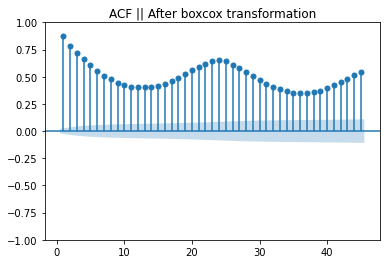

In [50]:
max_lag= 45
title = 'After boxcox transformation'
stld_plot = plot_acf(y_transf, lags=range(1, max_lag+1),  title='ACF || '+ title)

C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


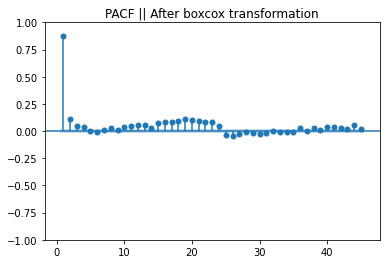

In [51]:
max_lag= 45
title = 'After boxcox transformation'
stld_plot = plot_pacf(y_transf, lags=range(1, max_lag+1), title='PACF || ' + title)

We can see that there is an PACF spike at LAG 1 and no protruding behaviour for the ACF. So our initial guesses are: ARIMA (1,0,0) and ARIMA (0,0,1). We also cannot really identify a seasonality in the data and therefore set it to 0. We want to use 7 days to train and one day to evaluate. Since we have timestamps every hour that will be 24 per day.

In [63]:
# set sizes and round them on full numbers
len_train = int(len(df_turbine_clean)*0.9+0.5)
len_val = int(len(df_turbine_clean)*0.05-0.25)
len_test = int(len(df_turbine_clean)*0.05-0.25)

In [64]:
# helper function to evaluate a SARIMA model

def eval_sarima(order, seasonal_order, n_train_sarima=7*24, n_eval_sarima=24, n_cvs=4, verbose=True, mode='search',
               exog=np.array([])):
    
    if mode=='search':
        start_train = len_train+len_val-n_cvs*n_eval_sarima-n_train_sarima
    else:
        start_train = len(df_turbine_clean)-n_cvs*n_eval_sarima-n_train_sarima
    
    test_value = start_train-n_eval_sarima if exog.any() else start_train
    if test_value < 0:
        raise ValueError('Training and development/test set too small. Reduce n_train_sarima and/or n_eval_sarima.')
    
    if verbose:
        print('Completed CV Splits (of {}): '.format(n_cvs), end='')
    
    me = 0
    mae = 0
    mape = 0
    rmse = 0
    preds_stacked = np.empty(0)
    for n_cv in range(1, n_cvs+1):
        y_train = boxcox(df_turbine_clean['WindSpeed'].values[start_train:start_train+n_train_sarima], lmbda=0.369667861173309 )
        if exog.any():
            X_train = exog[start_train-n_eval_sarima:start_train+n_train_sarima-n_eval_sarima]
            X_dev = exog[start_train+n_train_sarima-n_eval_sarima:start_train+n_train_sarima]
        else:
            X_train, X_dev = None, None
        y_dev = boxcox(df_turbine_clean['WindSpeed'].values[start_train+n_train_sarima:start_train+n_train_sarima+n_eval_sarima], lmbda=0.369667861173309 )
        model = ARIMA(y_train, exog=X_train, order=order, seasonal_order=seasonal_order)
        model = model.fit()
        preds = model.forecast(steps=n_eval_sarima, exog=X_dev)
        preds_stacked = np.append(preds_stacked, preds)
        me += np.mean(y_dev-preds) / n_cvs
        mae += np.mean(abs(y_dev- preds)) / n_cvs
        mape += np.mean( abs( y_dev[y_dev>0]-preds[y_dev>0] )/y_dev[y_dev>0] ) * 100 / n_cvs
        rmse += np.sqrt( np.mean( (y_dev-preds)**2 ) ) / n_cvs
        start_train += n_eval_sarima 
        
        if verbose:
            print(n_cv, end=',')
            
    return me, mae, mape, rmse, preds_stacked

In [65]:
def save_obj(obj, path, name):
    with open(path + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(path, name):
    with open(path + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [66]:
save=True
saveto=r'models_1/results_initialguess_arima'

order_ls = [(1,0,0),(0,0,1)]
min_rmse = np.inf
results = {}
results['bc'] = {}
for order in tqdm(order_ls):
    me, mae, mape, rmse, preds= eval_sarima(order=order, seasonal_order=(0,0,0,0))
    results['bc'][order] = (me, mae, mape, rmse, preds)
    print('\nFinished ARIMA({}, (0,0,0,0)). ME = {:.4f}, MAE = {:.4f}, MAPE = {:.4f}, RMSE = {:.4f}.\n'
          .format(order,results['bc'][order][0],results['bc'][order][1],results['bc'][order][2],results['bc'][order][3]))

if save:
    save_obj(results, '', saveto)

  0%|          | 0/2 [00:00<?, ?it/s]

Completed CV Splits (of 4): 1,2,

 50%|█████     | 1/2 [00:00<00:00,  3.53it/s]

3,4,
Finished ARIMA((1, 0, 0), (0,0,0,0)). ME = 0.0983, MAE = 0.6467, MAPE = 36.4077, RMSE = 0.7572.

Completed CV Splits (of 4): 1,

100%|██████████| 2/2 [00:00<00:00,  3.10it/s]

2,3,4,
Finished ARIMA((0, 0, 1), (0,0,0,0)). ME = 0.0695, MAE = 0.6325, MAPE = 36.0346, RMSE = 0.7207.



We can see that the ARIMA model performs in the same range as our initial models regarding MAE and RMSE, so it seems that the time series can be modelled by our current settings. So let us try to improve on thatby testing more settings.

In [66]:
save=True
saveto=r'models_1/results_initialguess_arima_'

order_ls = [(0,0,0),(1,1,0),(0,1,1),(2,0,0),(0,0,2),(3,0,0),(0,0,3),(4,0,0),(0,0,4)]
min_rmse = np.inf
results = {}
results['bc'] = {}
for order in tqdm(order_ls):
    me, mae, mape, rmse, preds= eval_sarima(order=order, seasonal_order=(0,0,0,0))
    results['bc'][order] = (me, mae, mape, rmse, preds)
    print('\nFinished ARIMA({}, (0,0,0,0)). ME = {:.4f}, MAE = {:.4f}, MAPE = {:.4f}, RMSE = {:.4f}.\n'
          .format(order,results['bc'][order][0],results['bc'][order][1],results['bc'][order][2],results['bc'][order][3]))

if save:
    save_obj(results, '', saveto)

  0%|          | 0/9 [00:00<?, ?it/s]

Completed CV Splits (of 4): 1,2,3,

 11%|█         | 1/9 [00:00<00:02,  3.25it/s]

4,
Finished ARIMA((0, 0, 0), (0,0,0,0)). ME = 0.0704, MAE = 0.6383, MAPE = 36.2236, RMSE = 0.7268.

Completed CV Splits (of 4): 1,2,

 22%|██▏       | 2/9 [00:00<00:01,  4.18it/s]

3,4,
Finished ARIMA((1, 1, 0), (0,0,0,0)). ME = 0.2216, MAE = 0.8475, MAPE = 46.5706, RMSE = 1.0177.

Completed CV Splits (of 4): 1,2,3,

 33%|███▎      | 3/9 [00:00<00:01,  4.16it/s]

4,
Finished ARIMA((0, 1, 1), (0,0,0,0)). ME = 0.2239, MAE = 0.8459, MAPE = 46.4093, RMSE = 1.0157.

Completed CV Splits (of 4): 1,2,

 44%|████▍     | 4/9 [00:01<00:02,  2.25it/s]

3,4,
Finished ARIMA((2, 0, 0), (0,0,0,0)). ME = 0.1022, MAE = 0.6467, MAPE = 36.3443, RMSE = 0.7568.

Completed CV Splits (of 4): 1,2,3,

 56%|█████▌    | 5/9 [00:02<00:02,  1.79it/s]

4,
Finished ARIMA((0, 0, 2), (0,0,0,0)). ME = 0.0827, MAE = 0.6430, MAPE = 36.4168, RMSE = 0.7339.

Completed CV Splits (of 4): 1,2,3,

 67%|██████▋   | 6/9 [00:02<00:01,  1.66it/s]

4,
Finished ARIMA((3, 0, 0), (0,0,0,0)). ME = 0.0948, MAE = 0.6443, MAPE = 36.3337, RMSE = 0.7525.

Completed CV Splits (of 4): 1,2,3,

 78%|███████▊  | 7/9 [00:03<00:01,  1.64it/s]

4,
Finished ARIMA((0, 0, 3), (0,0,0,0)). ME = 0.0711, MAE = 0.6330, MAPE = 36.0352, RMSE = 0.7303.

Completed CV Splits (of 4): 1,2,3,

 89%|████████▉ | 8/9 [00:04<00:00,  1.43it/s]

4,
Finished ARIMA((4, 0, 0), (0,0,0,0)). ME = 0.0709, MAE = 0.6283, MAPE = 35.8655, RMSE = 0.7276.

Completed CV Splits (of 4): 1,2,3,

100%|██████████| 9/9 [00:05<00:00,  1.66it/s]

4,
Finished ARIMA((0, 0, 4), (0,0,0,0)). ME = 0.0732, MAE = 0.6329, MAPE = 36.0297, RMSE = 0.7309.




At last, we want to investigate, if there is the possibility that differencing (1st and 2nd order) will help improving our model.

In [67]:
save=True
saveto=r'models_1/results_initialguess_arima_dif'

order_ls = [(0,0,1),(0,1,1),(0,2,1)]
min_rmse = np.inf
results = {}
results['bc'] = {}
for order in tqdm(order_ls):
    me, mae, mape, rmse, preds= eval_sarima(order=order, seasonal_order=(0,0,0,0))
    results['bc'][order] = (me, mae, mape, rmse, preds)
    print('\nFinished ARIMA({}, (0,0,0,0)). ME = {:.4f}, MAE = {:.4f}, MAPE = {:.4f}, RMSE = {:.4f}.\n'
          .format(order,results['bc'][order][0],results['bc'][order][1],results['bc'][order][2],results['bc'][order][3]))

if save:
    save_obj(results, '', saveto)

  0%|          | 0/3 [00:00<?, ?it/s]

Completed CV Splits (of 4): 1,2,3,

 67%|██████▋   | 2/3 [00:00<00:00,  3.55it/s]

4,
Finished ARIMA((0, 0, 1), (0,0,0,0)). ME = 0.0695, MAE = 0.6325, MAPE = 36.0346, RMSE = 0.7207.

Completed CV Splits (of 4): 1,2,3,4,
Finished ARIMA((0, 1, 1), (0,0,0,0)). ME = 0.2239, MAE = 0.8459, MAPE = 46.4093, RMSE = 1.0157.

Completed CV Splits (of 4): 1,2,3,

100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

4,
Finished ARIMA((0, 2, 1), (0,0,0,0)). ME = 0.2366, MAE = 0.8876, MAPE = 48.8635, RMSE = 1.0550.



We could not improve our settings by brute force testing other parameters and differecing orders. So, our best model choice remains with (0,0,1). We can clearly see that the ARIMA model captures the behaviour of the data best so far regarding the MAE and the RMSE, but not regarding the MAPE. Overall that does mean that is not necessarily the best method in our case, as we are in the range of the feature based models. A reason for that could be that the time series data looks pretty robust and similar in the end of the series. Lets use the model on our test data.

In [67]:
order, seasonal_order = (0,0,1), (0,0,0, 0)
results['test'] = {}
me, mae, mape, rmse, preds = eval_sarima(order, seasonal_order, mode='test', n_cvs=3)
results['test'][order] = (me, mae, mape, rmse, preds)
print('\nFinished ARIMA({}, (0,0,0,0)). ME = {:.4f}, MAE = {:.4f}, MAPE = {:.4f}, RMSE = {:.4f}.\n'
          .format(order,results['test'][order][0],results['test'][order][1],results['test'][order][2],results['test'][order][3]))

Completed CV Splits (of 3): 1,2,3,
Finished ARIMA((0, 0, 1), (0,0,0,0)). ME = 0.2249, MAE = 0.6516, MAPE = 31.8700, RMSE = 0.7458.



# V. LSTM

In this section, we try to model the data using a LSTM that was presented in the exercise and see if those are able to capture the data. At first, we make use of the functions that were introduced in the exercise to build and evaluate a neural network. In a first step we prepare our data such it fits the neural net.

In [69]:
#extract the information out of the timestamp
df_turbine_clean['hour'] = df_turbine_clean.timestamp.dt.hour
df_turbine_clean['day'] = df_turbine_clean.timestamp.dt.day
df_turbine_clean['month'] = df_turbine_clean.timestamp.dt.month
df_turbine_clean['year'] = df_turbine_clean.timestamp.dt.year
df_turbine_clean = df_turbine_clean.drop(columns=['timestamp'])

In [70]:
# split data into training, development and test sets
n_train = int(len(df_turbine_clean)*0.9+0.5)
n_dev = int(len(df_turbine_clean)*0.05-0.25)
n_test = int(len(df_turbine_clean)*0.05-0.25)


# one-hot encode categorical variables; ensure demand is last column
data_lstm = pd.concat([pd.get_dummies(df_turbine_clean.loc[:, df_turbine_clean.columns != "WindSpeed"], prefix='', prefix_sep=''), df_turbine_clean.WindSpeed], axis=1)
n_features = data_lstm.shape[1]

# scale the data
scaler = StandardScaler()
scaler = scaler.fit(data_lstm.iloc[:n_train+n_dev, :])
data_lstm = scaler.transform(data_lstm)

We will fix the number of timesteps at 24, i.e. in our case one day.

In [71]:
n_timesteps = 24
data_3d = []
for t in range(len(data_lstm)-n_timesteps):
    data_3d.append(data_lstm[t:t+n_timesteps, :])
data_3d = np.stack(data_3d)

X_train, y_train = data_3d[:n_train+n_dev-n_timesteps, :, :], data_lstm[n_timesteps:n_train+n_dev, -1].astype(float)
X_test, y_test = data_3d[n_train+n_dev-n_timesteps:, :, :], data_lstm[n_train+n_dev:, -1].astype(float)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7486, 24, 12) (7486,)
(395, 24, 12) (395,)


We use the predefined model functions from the exercise and adapt them to our use case.

In [72]:
def build_model(hidden_nodes, seed=42, input_shape=(n_timesteps, n_features)):
    
    # ensure reproducability of results for given hyperparameters by making initialization deterministic
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    model = Sequential()
    return_sequences = len(hidden_nodes)>1
    model.add(LSTM(hidden_nodes[0], input_shape=input_shape, return_sequences=return_sequences))
    if return_sequences:
        for n_nodes in hidden_nodes[1:-1]:
            model.add(LSTM(n_nodes, return_sequences=True))
        model.add(LSTM(hidden_nodes[-1], return_sequences=False))
    model.add(Dense(1))
    
    return model

In [73]:
def compile_model(model, lr, loss='mse', optimizer='adam'):
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr) if optimizer=='adam' else tf.keras.optimizers.SGD(learning_rate=lr)
    model.compile(loss=loss, optimizer=optimizer)
    
    return model

In [74]:
def cv_eval(hp, n_cvs=5, X=X_train, y=y_train, n_dev=n_dev, scaler=scaler, verbose=0):
    
    lr, hidden_nodes, max_epochs, patience, batch_size, seed = hp
    me_ls = []
    mae_ls = []
    mape_ls = []
    rmse_ls = []
    
    for n_cv in tqdm(range(1, n_cvs+1)):
        
        end_train = n_cv*int( (len(X)-n_dev) / n_cvs)
        X_tn, y_tn = X[:end_train, :, :], y[:end_train]
        X_dv, y_dv = X[end_train:end_train+n_dev, :, :], y[end_train:end_train+n_dev]
        
        model = build_model(hidden_nodes, seed)
        model = compile_model(model, lr)        
        callback = callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)                    
        history = model.fit(X_tn, y_tn, epochs=max_epochs, batch_size=batch_size, validation_data=(X_dv, y_dv), verbose=verbose,
                            shuffle=False, callbacks=[callback])
        
        # ensure rmse is computed in correct scale
        preds = scaler.inverse_transform(np.append(data_lstm[:n_dev, :-1], model.predict(X_dv), axis=1))[:, -1]
        y_true = scaler.inverse_transform(np.append(data_lstm[:n_dev, :-1], y_dv.reshape(-1, 1), axis=1))[:, -1]
        me_ls.append( np.mean(y_true-preds) )
        mae_ls.append( np.mean(abs(y_true- preds)))
        mape_ls.append( np.mean( abs( y_true[y_true>0]-preds[y_true>0] )/y_true[y_true>0] ) * 100)
        rmse_ls.append( np.sqrt( np.mean( (y_true-preds)**2 ) ) )
        
    weights = model.get_weights()
    
    return me_ls,mae_ls,mape_ls, rmse_ls, hp, weights, model

Lets initialise the model.

In [75]:
lr = .01
hidden_nodes = [64,64,64]
max_epochs = 100
patience = 20
batch_size = 128
seed = 0

hp = (lr, hidden_nodes, max_epochs, patience, batch_size, seed)
me_ls,mae_ls,mape_lss, rmse_ls, hp, weights, model = cv_eval(hp, verbose=0)

100%|██████████| 5/5 [19:58<00:00, 239.63s/it]


In [76]:
mape_lss

[17.279299954233984,
 35.890948044900036,
 33.76098983919768,
 25.97939489081062,
 17.970599812052086]

In [77]:
print('Finished LSTM.\nME={:.2f}. MAE={:.2f}. MAPE={:.2f}. RMSE={:.2f}.'.format(np.min(me_ls), np.min(mae_ls), np.min(mape_lss),np.min(rmse_ls)))

Finished LSTM.
ME=-0.31. MAE=0.74. MAPE=17.28. RMSE=0.98.


We see that the LSTM performs a bit worse than the previous models. However, due to the lack of computing power, we only tested a small number of different settings for the hidden node states. So, there might be a high probability that the model can perform better. Lets see how the model behaves on the test set.

In [78]:
lr, hidden_nodes, max_epochs, patience, batch_size, seed = hp
# create model with above hyperparameters
model = build_model(hidden_nodes)
model = compile_model(model, lr=lr, loss='mse', optimizer='adam')
model.set_weights(weights)

In [79]:
# predict on test set
preds_lstm = scaler.inverse_transform(np.append(data_lstm[:n_test, :-1], model.predict(X_test), axis=1))[:, -1]
y_true = df_turbine_clean['WindSpeed'].values[-n_test:].astype(float)
me = np.mean(y_true-preds_lstm) 
mae = np.mean(abs(y_true- preds_lstm)) 
mape = np.mean( abs( y_true[y_true>0]-preds_lstm[y_true>0] )/y_true[y_true>0] ) * 100
rmse = np.sqrt( np.mean( (y_true-preds_lstm)**2 ) ) 
print('Finished LSTM.\nME={:.2f}. MAE={:.2f}. MAPE={:.2f}. RMSE={:.2f}.'.format(me, mae, mape, rmse))

Finished LSTM.
ME=0.08. MAE=0.84. MAPE=17.40. RMSE=1.16.


# VI. GARCH 

In the last part of this notebook, we will make use of another model to predict our time series, in particular the GARCH model. A GARCH model (Generalized Autoregressive Conditional Heteroskedasticity) allows to model a change in variance over time, i.e. increasing or decreasing volatility in a time series. That is in contrast to the ARIMA model which is not able to capture the variance and that is the reason why we have to enforce stationarity for ARIMA models first. Since we do not have a stationary series without adjustments, we will try to model it with a GARCH model.

In [101]:
# set sizes and round them on full numbers
len_train = int(len(df_turbine_clean)*0.9+0.5)
len_val = int(len(df_turbine_clean)*0.05-0.25)
len_test = int(len(df_turbine_clean)*0.05-0.25)

In [102]:
# we create the datasets for our "normal" models SVM and RandomForest
X_train, y_train = df_turbine_clean[:len_train].drop(columns=['WindSpeed','timestamp']), df_turbine_clean[:len_train].WindSpeed
X_val, y_val = df_turbine_clean[len_train:len_train+len_val].drop(columns=['WindSpeed','timestamp']), df_turbine_clean[len_train:len_train+len_val].WindSpeed
X_test, y_test =  df_turbine_clean[len_train+len_val:].drop(columns=['WindSpeed','timestamp']), df_turbine_clean[len_train+len_val:].WindSpeed

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(7115, 7) (7115,)
(395, 7) (395,)
(395, 7) (395,)


After we have defined our sets, we will have a look at the autocorrelation function, which enables us to be able to model first estimates for the parameters of the GARCH model.

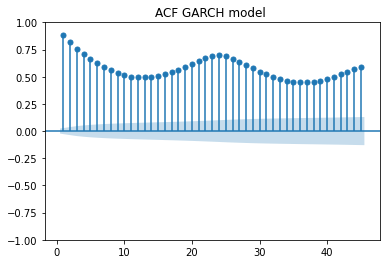

In [103]:
max_lag= 45
stld_plot = plot_acf(y_train, lags=range(1, max_lag+1),  title='ACF GARCH model ')

C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


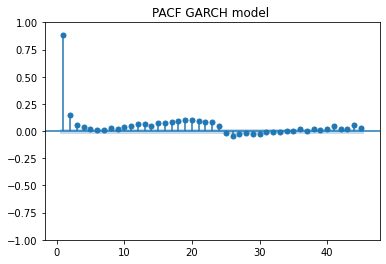

In [104]:
stld_plot = plot_pacf(y_train, lags=range(1, max_lag+1), title='PACF GARCH model ' )

We do not have a clear spike in the ACF, but the highest value in 1. On top of that, the PACF has a clear spike at 1. So, we will start with those values.

In [105]:
# define the dataset with the whole set and fit model on the indices of the training set
model = arch_model(df_turbine_clean[:len_train+len_val].WindSpeed, vol='GARCH', p=1,q=1)
model_fit = model.fit(last_obs = y_val.index[0])

Iteration:      1,   Func. Count:      6,   Neg. LLF: 334154149148850.0
Iteration:      2,   Func. Count:     15,   Neg. LLF: 3549097382.036089
Iteration:      3,   Func. Count:     22,   Neg. LLF: 17058.93885687083
Iteration:      4,   Func. Count:     28,   Neg. LLF: 19334.329109757928
Iteration:      5,   Func. Count:     35,   Neg. LLF: 27121.85792374809
Iteration:      6,   Func. Count:     42,   Neg. LLF: 15641.097210622083
Iteration:      7,   Func. Count:     48,   Neg. LLF: 15441.779885145468
Iteration:      8,   Func. Count:     53,   Neg. LLF: 15439.178710214797
Iteration:      9,   Func. Count:     58,   Neg. LLF: 15435.168028505836
Iteration:     10,   Func. Count:     63,   Neg. LLF: 15433.461425398482
Iteration:     11,   Func. Count:     68,   Neg. LLF: 15432.855617537916
Iteration:     12,   Func. Count:     73,   Neg. LLF: 15432.816164772466
Iteration:     13,   Func. Count:     78,   Neg. LLF: 15432.81449948785
Iteration:     14,   Func. Count:     83,   Neg. LLF: 15

In [106]:
#summary of the model
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:              WindSpeed   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -15432.8
Distribution:                  Normal   AIC:                           30873.6
Method:            Maximum Likelihood   BIC:                           30901.1
                                        No. Observations:                 7115
Date:                Sun, Apr 03 2022   Df Residuals:                     7114
Time:                        10:31:10   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             5.4133  7.109e-02     76.147      0.000 [  5.274,  5.553]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.7448  7.624e-02      9.768  1.544e-22 [  0.595,  0.894]
alpha[1]       0.6210  3.041e-02     20.421  1.078e-92 [  0.561,  0.681]
beta[1]        0.2767  3.746e-02      7.387  1.500e-13 [  0.203,  0.350]
========================================================================

Covariance estimator: robust
"""

In [107]:
#forecast the validation set and save the predictions
predictions = model_fit.forecast().residual_variance.loc[y_val.index]

C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [108]:
predictions

,h.1
7115,2.109535
7116,3.015648
7117,4.320383
7118,3.468773
7119,1.756994
...,...
7505,6.125069
7506,5.022001
7507,2.139045
7508,2.135310


In [109]:
me = np.mean(y_val-predictions["h.1"]) 
mae = np.mean(abs(y_val- predictions["h.1"])) 
mape = np.mean( abs( y_val[y_val>0]-predictions["h.1"][y_val>0] )/y_val[y_val>0] ) * 100
rmse = np.sqrt( np.mean( (y_val-predictions["h.1"])**2 ) ) 
print('\nME={:.2f}. MAE={:.2f}. MAPE={:.2f}. RMSE={:.2f}.'.format(me, mae, mape, rmse))


ME=0.30. MAE=2.87. MAPE=79.40. RMSE=3.45.


Unfortunately, the results are a lot worse than from the other models. We include a lag order of asymmetric innovation as well. 

In [110]:
# define the dataset with the whole set and fit model on the indices of the training set
model = arch_model(df_turbine_clean[:len_train+len_val].WindSpeed, vol='GARCH', p=1,q=1,o=1)
model_fit = model.fit(last_obs = y_val.index[0])
predictions = model_fit.forecast().residual_variance.loc[y_val.index]
me = np.mean(y_val-predictions["h.1"]) 
mae = np.mean(abs(y_val- predictions["h.1"])) 
mape = np.mean( abs( y_val[y_val>0]-predictions["h.1"][y_val>0] )/y_val[y_val>0] ) * 100
rmse = np.sqrt( np.mean( (y_val-predictions["h.1"])**2 ) ) 
print('\nME={:.2f}. MAE={:.2f}. MAPE={:.2f}. RMSE={:.2f}.'.format(me, mae, mape, rmse))

Iteration:      1,   Func. Count:      7,   Neg. LLF: 57723.741862272494
Iteration:      2,   Func. Count:     19,   Neg. LLF: 645673680.87269
Iteration:      3,   Func. Count:     26,   Neg. LLF: 18632.81379397362
Iteration:      4,   Func. Count:     33,   Neg. LLF: 15863.939043573795
Iteration:      5,   Func. Count:     41,   Neg. LLF: 15643.180433074906
Iteration:      6,   Func. Count:     48,   Neg. LLF: 1367510.2950872637
Iteration:      7,   Func. Count:     55,   Neg. LLF: 15460.274390961946
Iteration:      8,   Func. Count:     62,   Neg. LLF: 15493.559896149
Iteration:      9,   Func. Count:     69,   Neg. LLF: 15429.583388400946
Iteration:     10,   Func. Count:     75,   Neg. LLF: 15430.492388108887
Iteration:     11,   Func. Count:     82,   Neg. LLF: 15429.531658587272
Iteration:     12,   Func. Count:     88,   Neg. LLF: 15429.509974860171
Iteration:     13,   Func. Count:     94,   Neg. LLF: 15429.508151364469
Iteration:     14,   Func. Count:    100,   Neg. LLF: 1542

C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


We see that this improves the model a bit. But it is still far off. So, we will not use it on the test set. In research it is often common that different models are combined to evaluate data with a hybrid approach. 

# VII. GARCH and ARIMA

In the following section, we will evaluate if a combination of GARCH and ARIMA will perform better than the approaches itself. We will therefore fit the GARCH model on the residuals of the ARIMA model.

In [111]:
# we first use the ARIMA model to fit the data on our train set
y_train_tra = boxcox(df_turbine_clean[:len_train].WindSpeed, lmbda=0.369667861173309)
model = ARIMA(y_train_tra, order=(0, 0, 1), seasonal_order=(0, 0, 0, 0))
model = model.fit()
model.resid

array([-1.55982932, -1.11164168, -1.52793815, ..., -0.2249667 ,
       -0.15450934, -0.40475121])

In [112]:
# use our best GARCH model on the residuals of the ARIMA model
model_garch = arch_model(model.resid, vol='GARCH', p=1,q=1,o=1)
model_garch_fit = model_garch.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 21611.44659933509
Iteration:      2,   Func. Count:     16,   Neg. LLF: 1322081.6106950566
Iteration:      3,   Func. Count:     24,   Neg. LLF: 199342.21709150687
Iteration:      4,   Func. Count:     32,   Neg. LLF: 6289.748508544366
Iteration:      5,   Func. Count:     39,   Neg. LLF: 7516.308026284188
Iteration:      6,   Func. Count:     48,   Neg. LLF: 6073.918965526619
Iteration:      7,   Func. Count:     55,   Neg. LLF: 6161.4627500121205
Iteration:      8,   Func. Count:     62,   Neg. LLF: 6044.522466910063
Iteration:      9,   Func. Count:     69,   Neg. LLF: 6044.478014641057
Iteration:     10,   Func. Count:     76,   Neg. LLF: 6044.417077327247
Iteration:     11,   Func. Count:     82,   Neg. LLF: 6044.41700754924
Iteration:     12,   Func. Count:     87,   Neg. LLF: 6044.417007548742
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6044.41700754924
            Iterations: 12


We will now use the ARIMA model to estimate the mean, and afterwards the GARCH model for the variance in the residuals of the ARIMA estimation. So, that in the end, we can combine them for the final prediction.

In [136]:
# ARIMA for the mean
predicted_mu = model.forecast(steps=len_val)
# Use GARCH to predict the residual
garch_forecast = model_garch_fit.forecast(horizon=len_val)
predicted_et = garch_forecast.residual_variance.iloc[-1]

C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [137]:
# Combine the output of both models via yt = mu + et
prediction = predicted_mu + predicted_et
#reset index of prediction and validation to make it comparable
prediction = prediction.reset_index(drop=True)
y_val= y_val.reset_index(drop=True)

In [138]:
me = np.mean(y_val-prediction.reset_index(drop=True)) 
mae = np.mean(abs(y_val- prediction.reset_index(drop=True))) 
mape = np.mean( abs( y_val[y_val>0]-prediction.reset_index(drop=True) )/y_val[y_val>0] ) * 100
rmse = np.sqrt( np.mean( (y_val-prediction.reset_index(drop=True))**2 ) ) 
print('\nME={:.2f}. MAE={:.2f}. MAPE={:.2f}. RMSE={:.2f}.'.format(me, mae, mape, rmse))


ME=2.36. MAE=2.40. MAPE=42.32. RMSE=3.04.


We can see that the combination of both is better than the GARCH model itself, but still far off from our earlier results. So, we will not put further investigation into this and not predict the test set with the model.

# VIII. Outlook

At last, we will give an outlook on possible next steps and improvement opportunities.

* Due to limited computation power on CPU and next possible step is using GPU and perform exhaustive hyperparameter tuning.
* Change the set sizes of the validatio and test set to monitor the change of the algorithm.
* Try further hybrid models as suggested in research like combinations of EMD (decomposition) and predictions or genetic algorithms for optimization.
* Detailed error analysis